In [0]:
import keras
keras.__version__


'2.2.4'

In [0]:
import pandas as pd
df = pd.read_csv('mod.csv')
df.text=df.text.astype(str)

In [0]:
df = df.drop(columns='Unnamed: 0')
df.head()

,sentiment,text
0,positive,"Thank you, Ellen. We have a strong 2018, with ..."
1,positive,Stock-based compensation totaled $2.3 billion....
2,neutral,"For opening remarks, I will be turning the cal..."
3,positive,[Operator Instructions]. Our first question wi...
4,positive,"Hey, thanks. So I guess the question I have an..."


In [0]:
df['sentiment'] = df['sentiment'].replace({'positive': 0,'negative':1,'neutral':2})

In [0]:
X, y = (df['text'].values, df['sentiment'].values)

In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tk = Tokenizer(lower = True)
tk.fit_on_texts(X)
X_seq = tk.texts_to_sequences(X)
X_pad = pad_sequences(X_seq, maxlen=100, padding='post')

In [0]:
word_index = tk.word_index
print('Found {} unique tokens'.format(len(word_index)))

Found 6409 unique tokens


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pad, y, test_size = 0.25, random_state = 1)

In [0]:
import numpy as np
from keras.utils import to_categorical
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [0]:
import os
import numpy as np
glove_dir = 'glove6B'

embeddings_index = {}
f = open(os.path.join(os.getcwd(), 'glove.6B.100d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 100
max_words = 10000
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=100))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(3, activation='sigmoid'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 100, 100)          1000000   
_________________________________________________________________
flatten_11 (Flatten)         (None, 10000)             0         
_________________________________________________________________
dense_18 (Dense)             (None, 32)                320032    
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 99        
Total params: 1,320,131
Trainable params: 1,320,131
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Train on 1235 samples, validate on 412 samples
Epoch 1/10
1235/1235 [==============================] - 1s 952us/step - loss: 0.7089 - acc: 0.6570 - val_loss: 0.5882 - val_acc: 0.6998
Epoch 2/10
1235/1235 [==============================] - 0s 250us/step - loss: 0.5282 - acc: 0.7290 - val_loss: 0.5756 - val_acc: 0.7168
Epoch 3/10
1235/1235 [==============================] - 0s 248us/step - loss: 0.4547 - acc: 0.7811 - val_loss: 0.5978 - val_acc: 0.7168
Epoch 4/10
1235/1235 [==============================] - 0s 245us/step - loss: 0.3747 - acc: 0.8375 - val_loss: 0.5828 - val_acc: 0.7104
Epoch 5/10
1235/1235 [==============================] - 0s 239us/step - loss: 0.3069 - acc: 0.8750 - val_loss: 0.5832 - val_acc: 0.7257
Epoch 6/10
1235/1235 [==============================] - 0s 226us/step - loss: 0.2375 - acc: 0.9023 - val_loss: 0.6138 - val_acc: 0.7176
Epoch 7/10
1235/1235 [==============================] - 0s 205us/step - loss: 0.1778 - acc: 0.9366 - val_loss: 0.8533 - val_acc: 0.6893
E

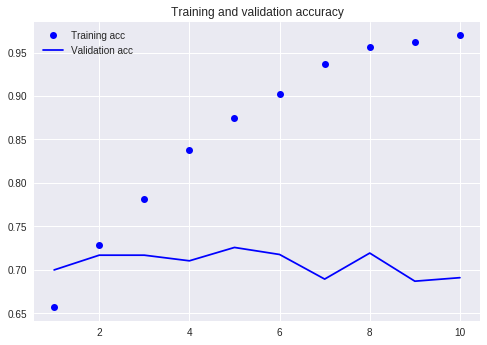

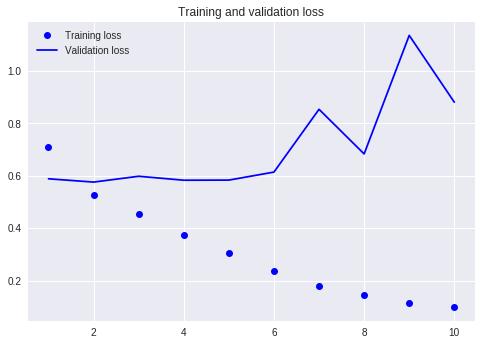

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
score = model.evaluate(X_test, y_test, verbose=1)
print('Test Loss:', score[0], 'Test Accuracy:', score[1])

412/412 [==============================] - 0s 85us/step
Test Loss: 0.8805231151071568 Test Accuracy: 0.6909385254082171


In [0]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

[[ 33  14 115]
 [  9   3  27]
 [ 25   8 178]]


##**TUNING THE MODEL**

In [0]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = True

In [0]:
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(X_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_data=(X_test, y_test))

Train on 1235 samples, validate on 412 samples
Epoch 1/10
1235/1235 [==============================] - 2s 1ms/step - loss: 0.0992 - acc: 0.9660 - val_loss: 0.7783 - val_acc: 0.7144
Epoch 2/10
1235/1235 [==============================] - 1s 521us/step - loss: 0.0728 - acc: 0.9773 - val_loss: 0.8944 - val_acc: 0.7071
Epoch 3/10
1235/1235 [==============================] - 1s 526us/step - loss: 0.0652 - acc: 0.9768 - val_loss: 0.8906 - val_acc: 0.7112
Epoch 4/10
1235/1235 [==============================] - 1s 528us/step - loss: 0.0604 - acc: 0.9792 - val_loss: 0.9161 - val_acc: 0.7071
Epoch 5/10
1235/1235 [==============================] - 1s 527us/step - loss: 0.0571 - acc: 0.9792 - val_loss: 0.9998 - val_acc: 0.6982
Epoch 6/10
1235/1235 [==============================] - 1s 509us/step - loss: 0.0539 - acc: 0.9811 - val_loss: 1.0187 - val_acc: 0.6974
Epoch 7/10
1235/1235 [==============================] - 1s 528us/step - loss: 0.0495 - acc: 0.9808 - val_loss: 1.0534 - val_acc: 0.6990
Epo

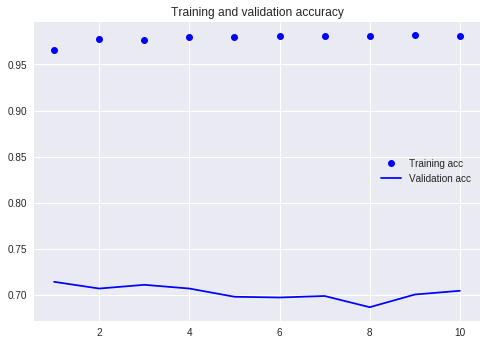

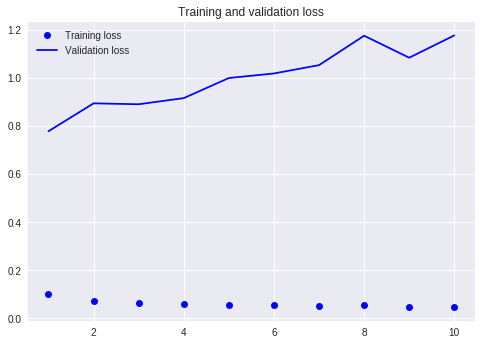

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

[[ 80   2  80]
 [ 20   1  18]
 [ 59   6 146]]


In [0]:
from keras.layers import Embedding
from keras.models import Sequential
from keras.layers import Flatten, Dense

model = Sequential()
# We specify the maximum input length to our Embedding layer
# so we can later flatten the embedded inputs
model.add(Embedding(10000, 8, input_length=100))
# After the Embedding layer, 
# our activations have shape `(samples, maxlen, 8)`.

# We flatten the 3D tensor of embeddings 
# into a 2D tensor of shape `(samples, maxlen * 8)`
model.add(Flatten())

# We add the classifier on top
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adamax', loss='binary_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_split=0.2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 100, 8)            80000     
_________________________________________________________________
flatten_13 (Flatten)         (None, 800)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)                 2403      
Total params: 82,403
Trainable params: 82,403
Non-trainable params: 0
_________________________________________________________________
Train on 988 samples, validate on 247 samples
Epoch 1/20
988/988 [==============================] - 1s 1ms/step - loss: 0.6022 - acc: 0.6677 - val_loss: 0.5799 - val_acc: 0.6815
Epoch 2/20
988/988 [==============================] - 0s 91us/step - loss: 0.5561 - acc: 0.6950 - val_loss: 0.5692 - val_acc: 0.6788
Epoch 3/20
988/988 [==============================] - 0s 89us/step - loss: 0.5426 - acc: 0.

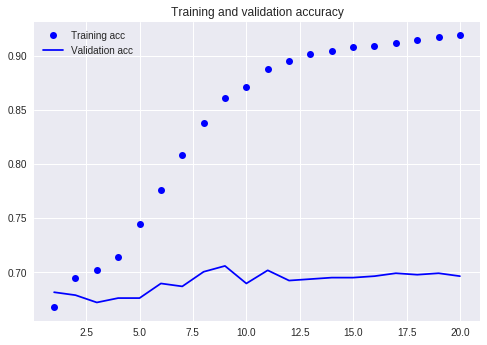

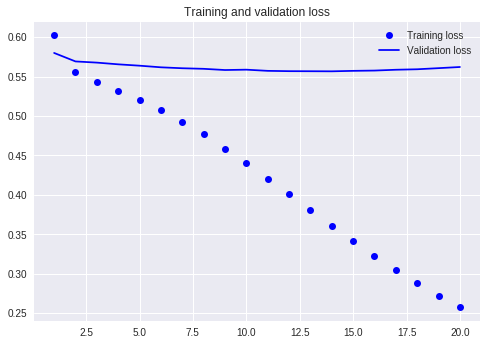

In [0]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1)))

[[ 84   0  78]
 [ 18   0  21]
 [ 54   0 157]]
